# Image Generation with Wasserstein Autoencoders

We'll build a deterministic Wasserstein autoencoder (WAE) to generate images of handwritten digits inspired by the MNIST dataset.

## The MNIST dataset

The MNIST dataset consists of grayscale images of hand-written digits from 0 to 9. Each image is 28 pixels by 28 pixels. There're 60,000 training images and 10,000 test images.

We've organized these images in two folders named `train` and `test` in the GitHub repository https://github.com/DeepTrackAI/MNIST_dataset:

In [1]:
import os

if not os.path.exists("MNIST_dataset"):
    os.system("git clone https://github.com/DeepTrackAI/MNIST_dataset")

base_dir = os.path.join("MNIST_dataset", "mnist", "train")

print(f"{len(os.listdir(base_dir))} training images")

60000 training images


We load the data using `Deeptrack2.0`. We will only use `6000` images for training and `6000` for test. We normalize the images in the range `[0, 1]`

In [2]:
import deeptrack as dt
import torch

dt.config.disable_image_wrapper()

paths = dt.sources.ImageFolder(root=base_dir)
train_paths, _, test_paths = dt.sources.random_split(paths, [0.1, 0.8, 0.1])

sources = dt.sources.Sources(train_paths, test_paths)

pipeline = (
    dt.LoadImage(sources.path)
    >> dt.NormalizeMinMax()
    >> dt.MoveAxis(2, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)

2024-01-12 12:29:16.719536: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


We will randomly choose and visualize some of the images in the dataset

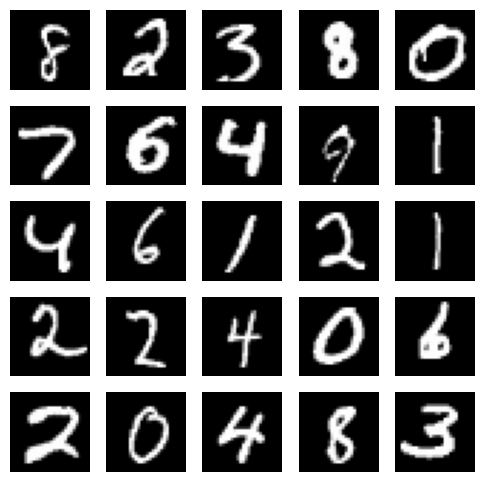

In [3]:
import matplotlib.pyplot as plt
from numpy import squeeze, random

fig, axs = plt.subplots(5, 5, figsize=((6, 6)))
for i, source in enumerate(random.choice(train_paths, 25)):
    image = pipeline(source)
    axs[i // 5, i % 5].imshow(squeeze(image), cmap="gray")
    axs[i // 5, i % 5].set_axis_off()

## Wasserstein autoencoder
We define the autoencoder architecture with a deterministic latent space of 8 dimension.

In [4]:
import deeplay as dl
import torchmetrics as tm
import torch
import torch.nn as nn

latent_dim = 8
wae = dl.WassersteinAutoEncoder(latent_dim=latent_dim).create()

print(wae)

WassersteinAutoEncoder(
  (encoder): ConvolutionalEncoder2d(
    (blocks): LayerList(
      (0): PoolLayerActivationNormalization(
        (pool): Identity()
        (layer): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
        (normalization): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): PoolLayerActivationNormalization(
        (pool): Identity()
        (layer): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (activation): ReLU()
        (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): PoolLayerActivationNormalization(
        (pool): Identity()
        (layer): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (activation): ReLU()
        (normalization): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (postprocess

We define the datasets, the dataloader and the trainer. We train the autoencder for `30` epochs.

In [5]:
from torch.utils.data import DataLoader

train_dataset = dt.pytorch.Dataset(pipeline & pipeline, inputs=train_paths)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

wae_trainer = dl.Trainer(max_epochs=30, accelerator="auto")
wae_trainer.fit(wae, train_loader)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/Users/841602/Documents/GitHub/Environments/deeplay_dev_env/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: 
  | Name                | Type                   | Params
---------------------------------------------------------------
0 | encoder             | ConvolutionalEncoder2d | 93.1 K
1 | fc_enc              | Linear                 | 50.2 K
2 | fc_dec              | Linear      

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=30` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


## Image Reconstruction

We define a pipeline to get images and labels of the test dataset.

In [6]:
def get_label(label_name):
    return int(label_name[0])


label = (
    dt.Value(get_label, label_name=sources.label_name)
    >> dt.Unsqueeze(0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)

test_dataset = dt.pytorch.Dataset(pipeline & label, inputs=test_paths)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

We check the WAE image reconstruction capability by comparing the input image with the autoencoder prediction

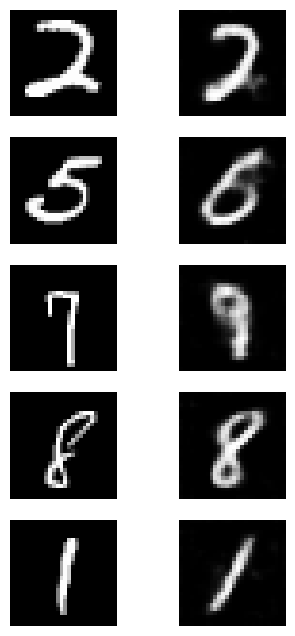

In [13]:
import numpy as np
from matplotlib import pyplot as plt

fig, axs = plt.subplots(5, 2, figsize=((4, 8)))

rnd_idx = np.random.randint(len(test_dataset), size=5)
for i, idx in enumerate(rnd_idx):
    image, label = test_dataset[idx]
    rec, _ = wae(image.unsqueeze(0))

    axs[i, 0].imshow(image.permute(1, 2, 0), cmap="gray")
    axs[i, 0].axis("off")
    axs[i, 1].imshow(rec.detach().squeeze(), cmap="gray")
    axs[i, 1].axis("off")

## Image Generation
We will generate images by sampling a continuous distribution of latent representations and reconstructing the images using the trained WAE’s decoder.

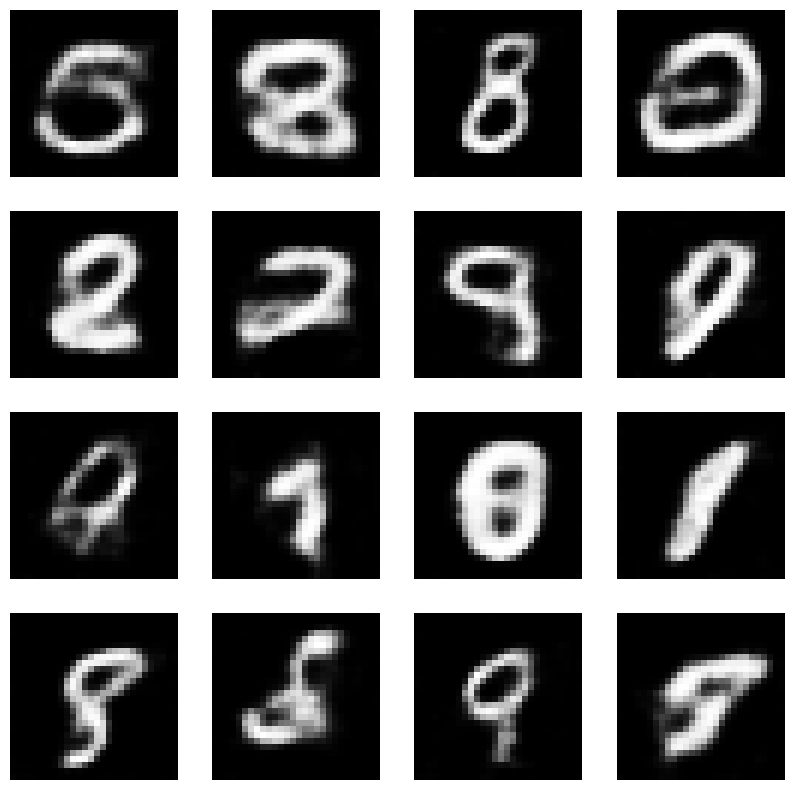

In [11]:
im = wae.decode(torch.randn(16, latent_dim)).detach().squeeze()

fig, axs = plt.subplots(4, 4, figsize=((10, 10)))
for i in range(16):
    axs[i // 4, i % 4].imshow(im[i], cmap="gray")
    axs[i // 4, i % 4].axis("off")

## Image interpolation
We can use the latent space to interpolate between pairs of images by encoding them, linearly interpolate between their latent-space representations and decode the corresponding images. 

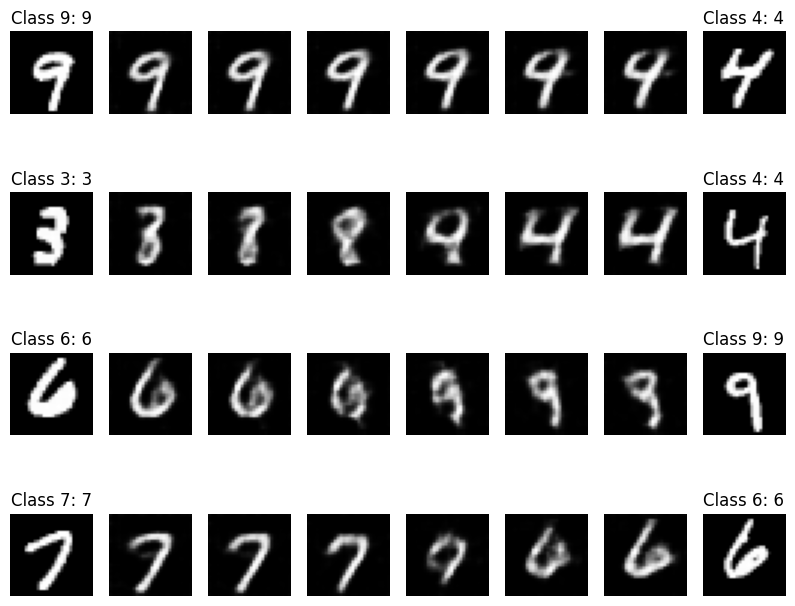

In [10]:
classes = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
n_steps = 6
n_im = 4
fig, axs = plt.subplots(n_im, n_steps + 2, figsize=((10, 8)))
rnd_idx = np.random.randint(len(test_dataset), size=(n_im, 2))


for j, idx in enumerate(rnd_idx):
    image0, label0 = test_dataset[idx[0]]
    label0 = label0.squeeze().numpy().astype(int)
    q_z0 = wae.encode(image0.unsqueeze(0))

    image1, label1 = test_dataset[idx[1]]
    label1 = label1.squeeze().numpy().astype(int)
    q_z1 = wae.encode(image1.unsqueeze(0))

    axs[j, 0].imshow(image0.squeeze(), cmap="gray")
    axs[j, 0].set_title("Class {}: {}".format(label0, classes[label0]))
    axs[j, 0].axis("off")

    for i in range(n_steps):
        q_i = q_z0 + (q_z1 - q_z0) * i / (n_steps - 1)
        rec_i = wae.decode(q_i).detach()
        axs[j, i + 1].imshow(rec_i.squeeze(), cmap="gray")
        axs[j, i + 1].axis("off")

    axs[j, n_steps + 1].imshow(image1.squeeze(), cmap="gray")
    axs[j, n_steps + 1].set_title("Class {}: {}".format(label1, classes[label1]))
    axs[j, n_steps + 1].axis("off")